# Modelos de Fotoionización

In [1]:
#Librerias a usar

import numpy as np
import pyCloudy as pc
import matplotlib.pyplot as plt
import pandas as pd

from astropy.io import fits
from astropy.wcs import WCS
from astropy.utils.data import get_pkg_data_filename
from PIL import Image

# Definimos las funciones a usar:

## Funciones para clasificar las regiones SF, TO y AGN.

In [2]:
def flag_kau (x,y):
    sfg_flag_kau = np.zeros(np.shape(x))
    y_kau_us = np.zeros(np.shape(x))
    #Regiones de Formación estelar (abajo de kuffmann) 
    for i in range(len(x)):
        #Función de Kuffmann
        y_kau_us[i] = np.divide(0.61,y[i]-0.05)+1.3 
        if x[i] <= y_kau_us[i] and y[i]<= 0.05:
            sfg_flag_kau[i] = 1.0
        else:
            sfg_flag_kau[i] = -9999.00
    
    return sfg_flag_kau

def flag_kew(x,y):
    sfg_flag_kew = np.zeros(np.shape(x))
    y_kew_us = np.zeros(np.shape(x))
    #Regiones bajo Kewley
    for i in range(len(x)):
        #Función de Kewley
        y_kew_us[i] = np.divide(0.61,y[i]-0.47)+1.19 
        if x[i] <= y_kew_us[i] and y[i] <= 0.47:
            sfg_flag_kew[i] = 1.0
        else:
            sfg_flag_kew[i] = -9999.00
    
    return sfg_flag_kew

## Funcion para dividir las regiones SF, TO y AGN.

In [3]:
def div(l_x,l_y,x,y):
    
    #Hacemos los flageos el diagrama BPT y las funciones de Kuffmann y Kewley
    sfg_flag_kau =  flag_kau (l_x,l_y)
    sfg_flag_kew =  flag_kew (l_x,l_y)
    
    #Regiones de Formacion estelar (abajo de kuffmann)
    rest01 = x[np.where(sfg_flag_kau == 1.0)]
    log_rest01 = y[np.where(sfg_flag_kau == 1.0)]

    #Región entre kuffmann y Kewley (TO's)
    doublet01 = np.logical_and(sfg_flag_kew == 1.0, sfg_flag_kau != 1.0)
    rest02 = x[np.where(doublet01)]
    log_rest02 = y[np.where(doublet01)]

    #Regiones de AGN (arriba de Kewley)
    rest03 = x[np.where(sfg_flag_kew != 1.0)]
    log_rest03 = y[np.where(sfg_flag_kew != 1.0)]
    
    return [rest01,log_rest01,rest02,log_rest02,rest03,log_rest03]

## Finción para generar los modelos.

In [5]:
def make_model(name, logU, Z, models_dir='./'):
    
    # Abundancias Z = 12 + log(n/n(H))
    # Las abundancias inicieles se asignan segun
    # la tabla del apéndice 1
    #Z_sol = {'He':11.00, 'Li':3.31, 'Be':1.42, 'B':2.79, 
    #         'C':8.39, 'N':7.93, 'O':8.69, 'F':4.48, 
    #         'Ne':8.00, 'Na':6.33,'Mg':7.54, 'Al':6.47, 
    #         'Si':7.54, 'P':5.51,'S':7.27, 'Cl':5.28, 
    #         'Ar':6.40, 'K':5.12, 'Ca':6.36, 'Sc':3.17, 
    #         'Ti':5.02, 'V':4.00, 'Cr':5.67, 'Mn':5.46,
    #         'Fe':7.45, 'Co':4.92,'Ni':6.25, 'Cu':4.21, 
    #         'Zn':4.60}
                
    Z_sol = {'He':11.00, 'C':8.39, 'N':7.93, 'O':8.69, 
             'Ne':8.00, 'Na':6.33,'Mg':7.54, 'Al':6.47, 
             'Si':7.54, 'S':7.27, 'Ar':6.40, 'Ca':6.36, 
             'Fe':7.45, 'Ni':6.25}
    
    # Variamos la abuncancia de N y S
    for elem in Z_sol:
        if elem == 'N' or elem == 'S':
        #if elem == 'O' :
            Z_sol[elem] = (Z_sol[elem]+Z)-12
        else:
            Z_sol[elem] -= 12
    
    options = ('no molecules',
               'no level2 lines',
               'no fine opacities',
               'atom h-like levels small',
               'atom he-like levels small',
              )
    
    # Tomamos un SED como una ley de potencias 
    # con un índice de energía de -1.4 en EUV 
    c_input = pc.CloudyInput('{0}/{1}'.format(models_dir, name))
    c_input.set_star(SED = 'power law slope', SED_params = -1.4,
                     lumi_unit = 'ionization parameter', lumi_value=logU)
     
    
    c_input.set_cste_density(3)
    # Definimos la densidad.
    c_input.set_abund(ab_dict = Z_sol, nograins = False)
    c_input.set_other(options)
    c_input.set_line_file('line_list.dat')
    c_input.set_iterate() 
    # (0) no iteraciones, () una iteración, (N) N iteraciones.
    c_input.set_sphere(False) 
    # () o (True) : espfera, or (False): open geometry.
    c_input.set_distance(dist=1, unit='kpc', linear=True) 
    # unidades pueden ser 'kpc', 'Mpc', 'parsecs', 'cm'.
    c_input.print_input()

## Función para correr los modelos.

In [6]:
def run_grid(models_dir, n_proc):
    pc.print_make_file(models_dir)
    
    # Variación de abundancias 
    Zs = np.array([-0.8,-0.6, -0.4,
                   -0.2, 0.0, 0.2, 
                   0.4, 0.6, 0.8,0.9])
    
    # Variación del parametro de ionización
    logUs = -np.arange(2.2,4.2,0.2)
    
    # Se hacen los inputs de los modelos 
    for Z in Zs:
        for logU in logUs:
            make_model(name='AGNNS_{0:.1f}_{1:.1f}'.format(logU, Z), 
                       logU=logU, Z=Z, models_dir=models_dir)
    # Corremos los modelos
    pc.run_cloudy(dir_ = models_dir, n_proc = n_proc)

## Funcíon para graficar la maya de modelos.

In [7]:
def plot_grid(Ms):
    
    x_NII_6584_1 = np.arange(-4.0,0.0,0.00001) #Para linea de Kuffmann
    x_NII_6584_2 = np.arange(-4.0,0.4,0.00001) #Para liena de Kewley 
    line_kuf = np.divide(0.61,x_NII_6584_1-0.05)+1.3
    line_kew = np.divide(0.61,x_NII_6584_2-0.47)+1.19
    
    # Función para extraer las intensidades de líneas para cada modelo:
    extract_line = lambda label:np.array([M.get_line(label) for M in Ms])
    Ha = extract_line('H__1_656281A')
    Hb = extract_line('H__1_486133A')
    O3 = extract_line('O__3_500684A')
    N2 = extract_line('N__2_658345A')
    
    # Recuperamos  la lista de valores
    # de los parámetros de entrada de los modelos:
    Z = np.array([float(M.model_name_s.split('_')[2]) for M in Ms])
    Z_u = np.sort(np.unique(Z))
    logU = np.array([float(M.model_name_s.split('_')[1]) for M in Ms])
    logU_u = np.sort(np.unique(logU))
    
    # Mostramos las regiones SF, TO y AGN
    plt.figure(figsize=(8,8), dpi=120)
    plt.scatter(rest_O3HbN2Ha[1],rest_O3HbN2Ha[0], 
                s=2, c='lightblue', marker='.',alpha=0.8)
    plt.scatter(rest_O3HbN2Ha[3],rest_O3HbN2Ha[2], 
                s=2, c='lightgreen', marker='.',alpha=0.5)
    plt.scatter(rest_O3HbN2Ha[5],rest_O3HbN2Ha[4], 
                s=2, c='rosybrown', marker='.',alpha=0.5)
   
    #Graficamos las líneas de Kuffmann y Kewley
    plt.plot(x_NII_6584_2,line_kew,'k-')
    plt.plot(x_NII_6584_1,line_kuf,'k--')
    table = pd.read_csv('data_NGC7469/SDSS_object/table1.dat',
                        header=None,sep='\s+')
    
    for logU1 in logU_u:
        s = np.where(logU == logU1)[0] 
        indx = s[Z[s].argsort()] 
        if logU1 == np.min(logU_u) or logU1 == np.max(logU_u):
            plt.plot(np.log10(N2/Ha)[indx], 
                     np.log10(O3/Hb)[indx], 
                     '-', linewidth=2, 
                     label = 'logU={0:.2f}'.format(logU1))
        else:
            plt.plot(np.log10(N2/Ha)[indx], 
                     np.log10(O3/Hb)[indx], 
                     '-k',linewidth=1)
        

        
    for Z1 in Z_u:
        s = np.where(Z == Z1)[0] 
        indx = s[logU[s].argsort()]
        if Z1 == np.min(Z_u) or Z1 == np.max(Z_u):
            plt.plot(np.log10(N2/Ha)[indx], 
                     np.log10(O3/Hb)[indx], 
                     '--', linewidth=2, 
                     label = 'Zneb={0:.2f}'.format(Z1))
        else:
            plt.plot(np.log10(N2/Ha)[indx], 
                     np.log10(O3/Hb)[indx], 
                     '--k', linewidth=1)

    plt.legend()
    plt.title('Densidad 3',fontsize = 25)
    plt.ylabel('$\log([OIII]\lambda5007/H \\beta )$',fontsize = 25)
    plt.xlabel('$\log([NII]\lambda6584/H \\alpha )$',fontsize = 25)
    plt.xlim(-2.0,1.0)
    plt.ylim(-2.0,1.5)
    plt.savefig("img_grf/BPT_MYMODEL_D2.jpg")

# Generamos los modelos

In [8]:
## Cargamos el archivo fits 
filename = get_pkg_data_filename('/home/echeveste/Downloads/nsa_v0_1_2.fits')
linea = fits.open(filename)[1].data

In [9]:
cond = ( (linea['N2FLUX'] != 0.) & (linea['HAFLUX'] != 0.) & 
         (linea['O3FLUX'] != 0.) & (linea['HBFLUX'] != 0.))

In [10]:
N2FLUX = linea['N2FLUX'][cond]
O3FLUX = linea['O3FLUX'][cond]
HAFLUX = linea['HAFLUX'][cond]
HBFLUX = linea['HBFLUX'][cond]

In [11]:
l_NII_6584 = np.log10(N2FLUX / HAFLUX)
l_OIII_5007 = np.log10(O3FLUX / HBFLUX)

/usr/lib/python3/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log10
  """Entry point for launching an IPython kernel.
/usr/lib/python3/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log10
  


In [12]:
## Dividimos las regiones SF's, TO's y AGN
rest_O3HbN2Ha = div(l_OIII_5007,l_NII_6584,l_OIII_5007, l_NII_6584)

In [13]:
### Aquí comienza el programa principal ###
models_dir = '/home/echeveste/Mis_trabajos/astro_ssp/TESIS/models/model_p_4/'
pc.config.cloudy_exe = '/home/echeveste/Cloudy/source/cloudy.exe'

In [14]:
#run_grid(models_dir, n_proc=3)

In [15]:
Maya = pc.load_models(models_dir + '/AGNNS',
                      read_lin = True, read_emis = False, 
                      read_cont = False, list_elem = [], 
                      read_phy = False, read_rad=False)

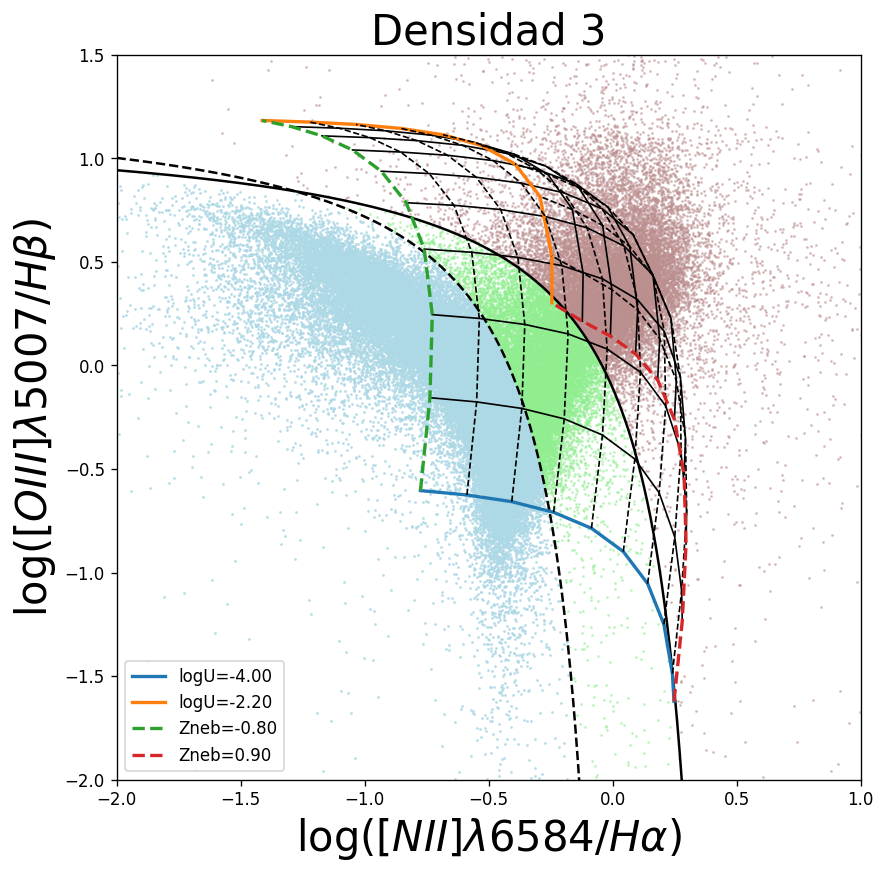

In [16]:
plot_grid(Maya)